# DQN-Based Recommending System

## Initialization

In [1]:
import os
import logging
import math
import random
import googleapiclient.discovery
# logging.getLogger().setLevel(logging.INFO)

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import requests
from IPython.display import display, Image
from collections import namedtuple

## Settings

In [2]:
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10
BATCH_SIZE = 128
DEBUG = False
API_KEY = ""
CATEGORIES = [
    ("Film & Animation", 1),
    ("Autos & Vehicles", 2),
    ("Music", 10),
    ("Pets & Animals", 15),
    ("Sports", 17),
    ("Travel & Events", 19),
    ("Gaming", 20),
    ("People & Blogs", 22),
    ("Comedy", 23),
    ("Entertainment", 24),
    ("News & Politics", 25),
    ("Howto & Style", 26),
    ("Education", 27),
    ("Science & Technology", 28), ]

## Functions

### RL-related

In [3]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))
class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)
class DQN(nn.Module):
    def __init__(self, in_channels, num_actions):
        super(DQN, self).__init__()
        self.line1 = nn.Linear(in_channels, 100)
        self.relu = nn.ReLU()
        self.line2 = nn.Linear(100, num_actions)

    def forward(self, x):
        x = self.line1(x)
        x = self.line2(x)
        return x.view(x.size(0), -1)
def generate_empty_states():
    return torch.zeros(1, len(CATEGORIES), device=device)
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()
def select_action(state, i_episode):
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * i_episode / EPS_DECAY)
    if sample+100 > eps_threshold:
        # Select an action based on Policy Network
        if DEBUG:
            print("Select Action: Network")
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        # Select an random action
        if DEBUG:
            print("Select Action: Random")
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

### API-related

In [4]:
def find_videos_of_category(category_id, page_token):
    youtube = googleapiclient.discovery.build("youtube", "v3", developerKey=API_KEY, cache_discovery=False)
    request = youtube.search().list(
        part="snippet",
        location="23.97387,120.98202", # Center of Taiwan
        locationRadius="150km", # Restrict Search scope to Taiwan
        order="viewCount",
        pageToken=page_token,
        relevanceLanguage="zh-Hant",
        type="video",
        videoCategoryId=category_id
    )
    logging.debug("API Called")
    response = request.execute()
    return response["nextPageToken"], response["items"]
def filter_rated(videos, rated):
    pop_ind = []
    for ind, vid in enumerate(videos):
        if vid["id"]["videoId"] in rated:
            pop_ind.append(ind)
    for ind in pop_ind[::-1]:
        videos.pop(ind)
    return videos
def show_video(video_dict):
    print("{} ({})".format(video_dict["snippet"]["title"], video_dict["id"]["videoId"]))
    display(Image(video_dict["snippet"]["thumbnails"]["medium"]["url"]))
def ind_to_id(tensor_index):
    return CATEGORIES[tensor_index][1]

# Main Train Loop

* state:  Category Scores
* action: Choose a categories, call function to retrieve video
* reward: User giving a respond of a Real Number between [10, 10]

In [5]:
input_channels = n_actions = len(CATEGORIES)
policy_net = DQN(input_channels, n_actions).to(device)
target_net = DQN(input_channels, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)

20140531《千と千尋の神隠し》神隱少女 Spirited Away Cosplay Video (n4EhCtg3DHA)


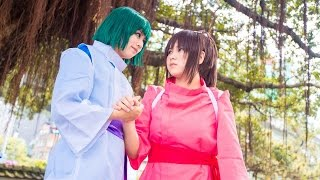

Score [-10, 10]：8
108年全國運動會 搭機捷挺全運 (jz4WqzrNw88)


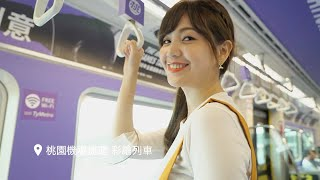

Score [-10, 10]：6
2002.4.9. 花東線東里站路牌拋接 (dmfB8JMWENc)


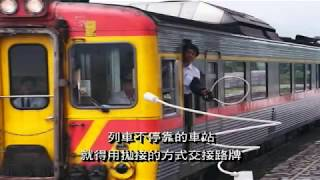

Score [-10, 10]：5
Motorcycle gangs VS. Taiwan police 飆車族 VS.台灣警察 (zUPpKiKRIMw)


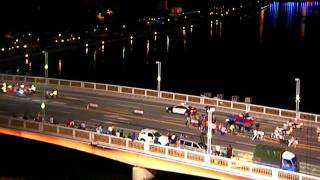

Score [-10, 10]：4
猴塞雷 拖車倒車  一次就到位 (5cOhf6ZxUzs)


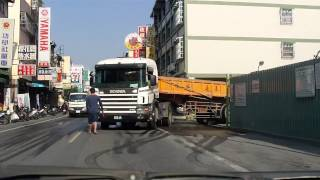

Score [-10, 10]：1
陸軍變形金剛，車變船船變橋叫做M3 Amphibious Bridging car。新北市消防救災演習 (wkV0-6AA1PM)


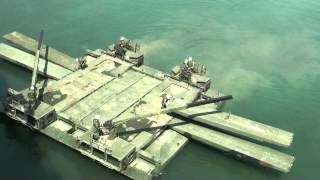

Score [-10, 10]：2
TOYOTA 全新12代Corolla Altis【新車搶先看直播】 (3uk4BaA54Vk)


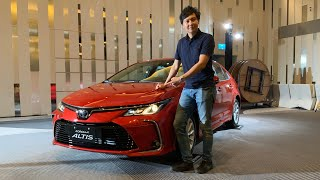

Score [-10, 10]：5
看過&quot;貨櫃車&quot;龍嗎?? (vVTzKbCB6Y8)


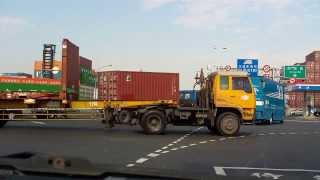

Score [-10, 10]：1
【路平專案】感謝韓國瑜市長李四川副市長團隊馬路真的鋪平了【第4部】2019.01.17後鏡頭(鳳山區青年路二段)【共4部】 (hcT1VIbZiCc)


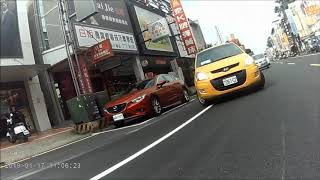

Score [-10, 10]：-5
大昶吊車吊掛怪手的重心Demag AC 395 (7ZQgik7EinU)


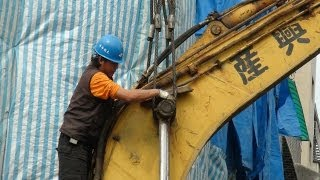

Score [-10, 10]：0


In [6]:
NUM_EPISODES = 10
state = generate_empty_states()
rated = {}
for i_episode in range(NUM_EPISODES):
    # Select a Category
    action = select_action(state, i_episode)
    cat_id = ind_to_id(int(action))
    
    # Find a video of the category
    page_token = filtered_videos = ""
    while not filtered_videos:
        page_token, videos = find_videos_of_category(cat_id, page_token)
        filtered_videos = filter_rated(videos.copy(), rated)
    video = random.choice(filtered_videos)
    show_video(video)
    
    # User Rating
    reward = float(input("Score [-10, 10]："))
    rated[video["id"]["videoId"]] = reward
    
    # Generate Next State (Interaction History)
    next_state = state.clone()
    next_state[0][action] += reward
    reward = torch.tensor([reward], device=device)
    
    # push to Memory Replay
    memory.push(state, action, next_state, reward)
    state = next_state
    
    # Optimize Model
    optimize_model()
    if i_episode % 1 == 0:
        target_net.load_state_dict(policy_net.state_dict())